# 필요한 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
from sklearn.metrics import mean_absolute_error
import pickle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings(action='ignore')

# 데이터로드

In [2]:
fm_data_df = pd.DataFrame(columns=['이름','포지션','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

In [3]:
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)

In [4]:
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

In [5]:
forward_df = fm_data_df[fm_data_df['포지션']=='공격수']
midfielder_df = fm_data_df[fm_data_df['포지션']=='미드필더']
defender_df = fm_data_df[fm_data_df['포지션']=='수비수']

In [6]:
forward_df.sort_values(by='평균획득승점/경기',ascending=False)

,이름,포지션,골,도움,경기당 팀 득점/90,경기당 팀 실점/90,크로스 성공률,파울 획득,반칙 수/90,기회 창출/90,...,크로스 시도/90,평균획득승점/경기,시즌,구단,리그,임대 기간,승,무,패,출장시간
1491,Timo Werner,공격수,7,1,3.06,0.34,30.0,25,0.85,0.17,...,1.95,2.89,2022-2023,FC 바이에른,독일 분데스리가,0,17.0,1.0,0.0,1060.0
1498,Dušan Vlahović,공격수,11,4,2.36,0.50,42.0,35,1.18,0.31,...,1.18,2.79,2022-2023,FC 바이에른,독일 분데스리가,23/1/27 - 23/6/30,17.0,2.0,0.0,1452.0
92,Leroy Sané,공격수,9,0,2.49,0.91,34.0,16,0.98,0.53,...,5.51,2.64,2021-2022,FC 바이에른,독일 분데스리가,0,24.0,2.0,2.0,1193.0
2345,Phil Foden,공격수,14,11,2.19,0.65,20.0,41,0.95,0.46,...,1.89,2.57,2022-2023,맨시티,잉글랜드 프리미어 리그,0,42.0,5.0,4.0,3903.0
4204,Christian Eriksen,공격수,7,5,1.79,0.38,28.0,15,0.68,0.17,...,1.67,2.57,2023-2024,인테르,이탈리아 세리에 A,0,37.0,7.0,2.0,2107.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4045,Federico Ricci,공격수,4,4,0.58,1.91,27.0,55,0.80,0.15,...,9.32,0.45,2023-2024,레지나,이탈리아 세리에 A,0,4.0,6.0,30.0,3583.0
3624,Yanis Begraoui,공격수,7,1,0.86,1.91,40.0,69,0.73,0.16,...,0.61,0.45,2023-2024,툴루즈,프랑스 리그 1,0,3.0,4.0,22.0,2210.0
3627,Antoine Leautey,공격수,1,2,0.82,2.10,28.0,12,1.52,0.29,...,4.96,0.42,2023-2024,툴루즈,프랑스 리그 1,0,3.0,4.0,24.0,1543.0
1587,Felix Platte,공격수,6,0,1.21,2.60,46.0,48,0.58,0.12,...,0.75,0.38,2022-2023,SC 파더보른,독일 분데스리가,0,1.0,7.0,18.0,1556.0


In [7]:
midfielder_df.sort_values(by='평균획득승점/경기',ascending=False)

,이름,포지션,골,도움,경기당 팀 득점/90,경기당 팀 실점/90,크로스 성공률,파울 획득,반칙 수/90,기회 창출/90,...,크로스 시도/90,평균획득승점/경기,시즌,구단,리그,임대 기간,승,무,패,출장시간
3936,Callum Hudson-Odoi,미드필더,6,4,3.09,0.54,32.0,21,0.54,0.08,...,5.25,2.66,2023-2024,첼시,잉글랜드 프리미어 리그,0,25.0,2.0,2.0,1166.0
822,Ander Herrera,미드필더,4,2,1.96,0.67,10.0,14,1.83,0.37,...,0.79,2.66,2021-2022,파리-SG,프랑스 리그 1,0,33.0,2.0,3.0,2163.0
3940,Conor Gallagher,미드필더,1,8,2.36,0.51,23.0,11,1.01,0.62,...,0.96,2.64,2023-2024,첼시,잉글랜드 프리미어 리그,0,28.0,3.0,2.0,1600.0
99,Corentin Tolisso,미드필더,2,4,2.39,0.74,15.0,4,1.97,0.16,...,1.07,2.61,2021-2022,FC 바이에른,독일 분데스리가,0,27.0,5.0,1.0,1094.0
2335,Ferland Mendy,미드필더,2,3,2.19,0.56,29.0,32,1.36,0.11,...,8.50,2.59,2022-2023,맨시티,잉글랜드 프리미어 리그,0,38.0,5.0,3.0,3983.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,Edu Expósito,미드필더,5,4,0.90,2.13,28.0,33,1.30,0.15,...,0.65,0.39,2023-2024,에이바르,스페인 프리메라 디비전,0,2.0,8.0,26.0,2909.0
2490,Soualiho Meïté,미드필더,0,0,0.41,1.82,16.0,14,1.33,0.17,...,0.50,0.38,2022-2023,웨스트 브롬,잉글랜드 프리미어 리그,0,1.0,3.0,12.0,1086.0
2794,Arthur Masuaku,미드필더,0,1,0.52,1.72,24.0,19,1.49,0.06,...,6.59,0.37,2022-2023,칼리아리,이탈리아 세리에 A,0,2.0,1.0,16.0,1571.0
1199,Arnór Sigurðsson,미드필더,1,1,0.48,1.35,30.0,36,1.57,0.04,...,3.39,0.37,2021-2022,베네치아,이탈리아 세리에 A,21/7/5 - 22/6/30,1.0,8.0,21.0,2070.0


In [8]:
defender_df.sort_values(by='평균획득승점/경기',ascending=False)

,이름,포지션,골,도움,경기당 팀 득점/90,경기당 팀 실점/90,크로스 성공률,파울 획득,반칙 수/90,기회 창출/90,...,크로스 시도/90,평균획득승점/경기,시즌,구단,리그,임대 기간,승,무,패,출장시간
3663,João Palhinha,수비수,2,2,2.14,0.17,0.0,8,1.54,0.17,...,0.26,2.88,2023-2024,파리-SG,프랑스 리그 1,0,16.0,1.0,0.0,1050.0
2346,John Stones,수비수,0,0,2.24,0.40,0.0,11,0.50,0.10,...,0.15,2.80,2022-2023,맨시티,잉글랜드 프리미어 리그,0,27.0,3.0,0.0,1806.0
1161,Marash Kumbulla,수비수,0,2,2.84,0.63,0.0,5,0.95,0.16,...,0.08,2.75,2021-2022,로마,이탈리아 세리에 A,20/9/17 - 22/6/30,14.0,2.0,0.0,1141.0
3945,Antonio Rüdiger,수비수,4,3,2.41,0.73,14.0,12,0.99,0.04,...,1.46,2.64,2023-2024,첼시,잉글랜드 프리미어 리그,0,22.0,0.0,3.0,2093.0
2339,Fabián,수비수,1,2,2.21,0.74,0.0,22,0.70,0.22,...,0.33,2.63,2022-2023,맨시티,잉글랜드 프리미어 리그,0,35.0,3.0,3.0,2439.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3638,Maya Yoshida,수비수,0,2,0.80,1.69,21.0,5,0.90,0.10,...,1.39,0.33,2023-2024,툴루즈,프랑스 리그 1,23/7/7 - 24/6/30,1.0,1.0,10.0,904.0
3636,Cédric Hountondji,수비수,0,0,0.58,2.42,0.0,3,0.75,0.08,...,0.00,0.25,2023-2024,툴루즈,프랑스 리그 1,0,1.0,0.0,11.0,1080.0
3648,Rocky Bushiri,수비수,0,0,0.59,1.94,51.0,8,1.18,0.17,...,2.45,0.24,2023-2024,트르와,프랑스 리그 1,0,1.0,1.0,15.0,1066.0
3647,Jimmy Giraudon,수비수,0,0,0.61,1.75,0.0,7,0.67,0.13,...,0.13,0.19,2023-2024,트르와,프랑스 리그 1,0,1.0,0.0,15.0,1338.0


In [9]:
defender_df.columns

Index(['이름', '포지션', '골', '도움', '경기당 팀 득점/90', '경기당 팀 실점/90', '크로스 성공률',
       '파울 획득', '반칙 수/90', '기회 창출/90', '경기당 유효 슈팅/90', '경기당 슈팅/90', '인터셉트/90',
       '달린 거리/90분', '공중볼시도/90', '태클 성공률', '경기당 패스 시도/90', '경기당 패스 성공/90',
       '키패스/90', '태클 성공/90', '드리블 성공/90', '헤더 성공/90', '크로스 시도/90', '평균획득승점/경기',
       '시즌', '구단', '리그', '임대 기간', '승', '무', '패', '출장시간'],
      dtype='object')

In [10]:
use_col = ['골','도움','크로스 성공률','파울 획득','반칙 수/90', '기회 창출/90', '경기당 유효 슈팅/90', '경기당 슈팅/90', '인터셉트/90',
       '달린 거리/90분', '공중볼시도/90', '태클 성공률', '경기당 패스 시도/90', '경기당 패스 성공/90',
       '키패스/90', '태클 성공/90', '드리블 성공/90', '헤더 성공/90', '크로스 시도/90','평균획득승점/경기']

def get_rf_regressor_f_importance(data):
    rf_reg = RandomForestRegressor(n_estimators=1000,random_state=123,bootstrap=True,oob_score=True)
    rf_reg.fit(data.loc[:,use_col[:-1]],data.loc[:,use_col[-1]])
    
    f_importance_dict = {}
    
    for col,fi in zip(use_col[:-1],rf_reg.feature_importances_):
        f_importance_dict[col] = fi
    return sorted(f_importance_dict.items(),key=lambda x : x[1], reverse=True)


forward_fi = get_rf_regressor_f_importance(forward_df)
midfielder_fi = get_rf_regressor_f_importance(midfielder_df)
defender_fi = get_rf_regressor_f_importance(defender_df)

In [11]:
forward_fi 

[('골', 0.14191452683448724),
 ('경기당 유효 슈팅/90', 0.13109548858141606),
 ('공중볼시도/90', 0.08757001491717493),
 ('드리블 성공/90', 0.06752454555324255),
 ('경기당 슈팅/90', 0.06355280497204503),
 ('경기당 패스 시도/90', 0.06208036510118691),
 ('도움', 0.05489210323169936),
 ('태클 성공/90', 0.05119328280788684),
 ('경기당 패스 성공/90', 0.04790113442575771),
 ('키패스/90', 0.047131510716919324),
 ('파울 획득', 0.03289927351994384),
 ('크로스 시도/90', 0.03193592124413982),
 ('반칙 수/90', 0.030316868236964993),
 ('헤더 성공/90', 0.028145927862104767),
 ('인터셉트/90', 0.027014187610562967),
 ('기회 창출/90', 0.025924420782459844),
 ('크로스 성공률', 0.025101735263152465),
 ('달린 거리/90분', 0.022117002732003642),
 ('태클 성공률', 0.021688885606851647)]

In [12]:
midfielder_fi

[('경기당 유효 슈팅/90', 0.12291045101102598),
 ('경기당 패스 시도/90', 0.08583402100235846),
 ('태클 성공/90', 0.08530823776636502),
 ('드리블 성공/90', 0.06813545430589378),
 ('도움', 0.06524654746324332),
 ('공중볼시도/90', 0.05299517284835075),
 ('크로스 시도/90', 0.05001934004280465),
 ('헤더 성공/90', 0.04819642264169581),
 ('경기당 슈팅/90', 0.04761773521690375),
 ('경기당 패스 성공/90', 0.04682671473449295),
 ('기회 창출/90', 0.045467488381670855),
 ('파울 획득', 0.04392127113841008),
 ('반칙 수/90', 0.04199373922869525),
 ('키패스/90', 0.04129256356339057),
 ('인터셉트/90', 0.038442860932387496),
 ('태클 성공률', 0.03256979248774201),
 ('크로스 성공률', 0.031719162710693694),
 ('달린 거리/90분', 0.027480738143072378),
 ('골', 0.02402228638080326)]

In [403]:
defender_fi

[('경기당 패스 시도/90', 0.14568143899385114),
 ('드리블 성공/90', 0.0868179049468631),
 ('헤더 성공/90', 0.06290382706758979),
 ('공중볼시도/90', 0.059609004077409725),
 ('경기당 패스 성공/90', 0.0549551349117865),
 ('크로스 시도/90', 0.053540577955732416),
 ('경기당 슈팅/90', 0.05247313529159307),
 ('태클 성공/90', 0.05017065330764311),
 ('인터셉트/90', 0.048715833893152906),
 ('기회 창출/90', 0.046728629044224576),
 ('파울 획득', 0.045897832351390444),
 ('태클 성공률', 0.04489370421181744),
 ('도움', 0.043732754756514496),
 ('반칙 수/90', 0.043465281829013776),
 ('키패스/90', 0.04197297089265451),
 ('경기당 유효 슈팅/90', 0.039224097301759554),
 ('달린 거리/90분', 0.03578830221109759),
 ('크로스 성공률', 0.028814057347750357),
 ('골', 0.014614859608155463)]

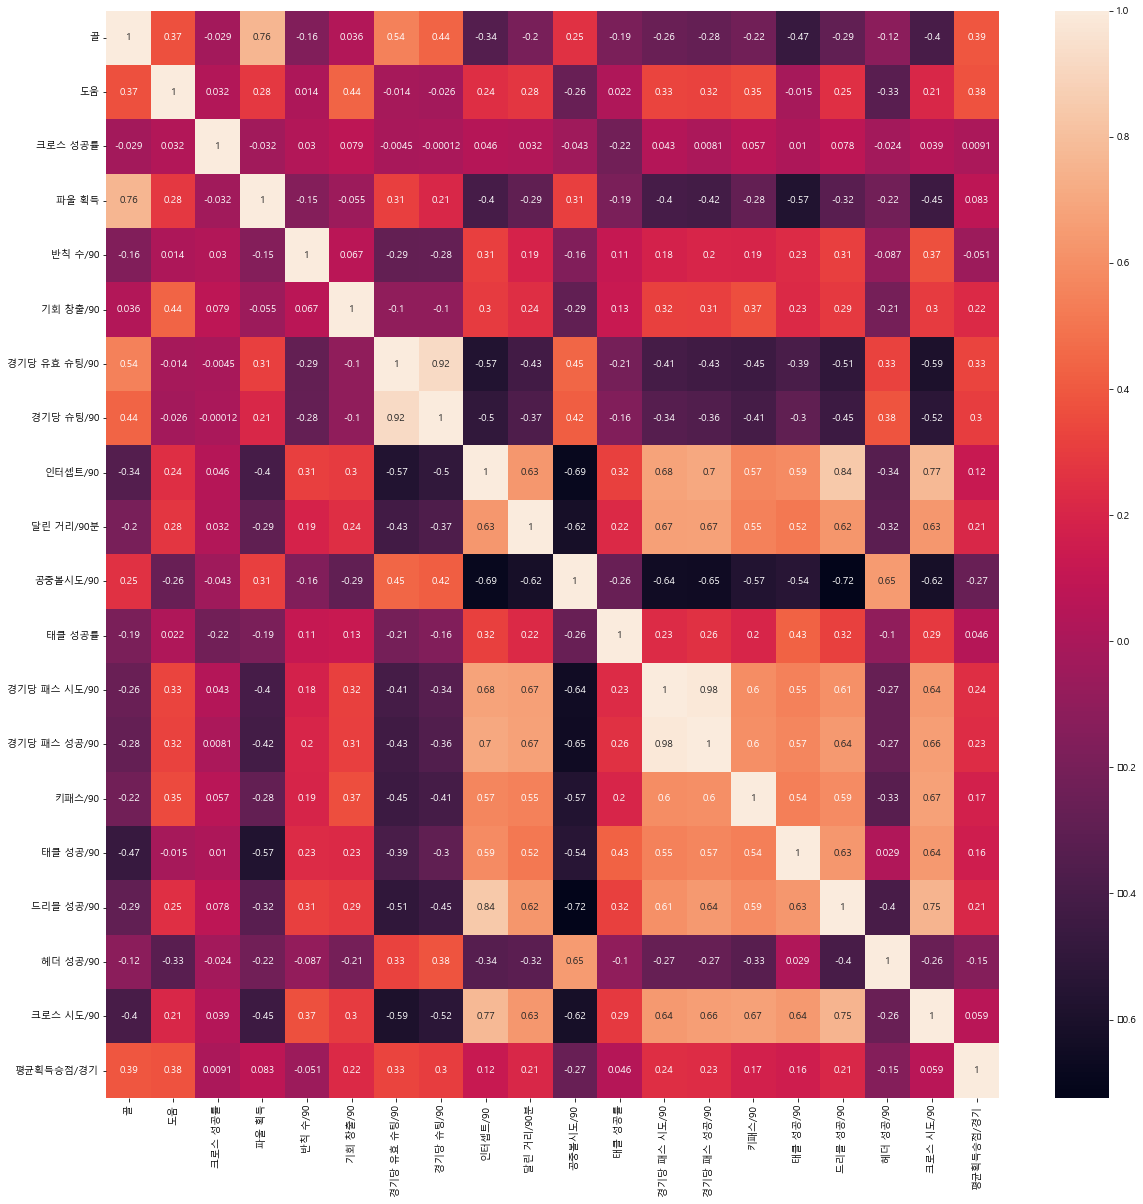

In [404]:
plt.figure(figsize=(20,20))
sns.heatmap(forward_df.loc[:,use_col].corr(),annot=True)
plt.show()

In [405]:
def get_corr_use(df):
    
    df = df.loc[:,use_col].corr()

    this_corr = defaultdict(tuple)

    for col in df.columns:
        for index in df.index:
            if df.loc[col,index] <= -0.6:
                this_corr[tuple(set([col,index]))] = df.loc[col,index]
            elif fcorr_df.loc[col,index] >= 0.6 and fcorr_df.loc[col,index] < 1.0:
                this_corr[tuple(set([col,index]))] = df.loc[col,index]
            
    return this_corr

In [406]:
forward_corr = get_corr_use(forward_df)
forward_corr

defaultdict(tuple,
            {('경기당 유효 슈팅/90', '경기당 슈팅/90'): 0.9215610231492737,
             ('달린 거리/90분', '인터셉트/90'): 0.6339070539236573,
             ('공중볼시도/90', '인터셉트/90'): -0.6876113072570983,
             ('경기당 패스 시도/90', '인터셉트/90'): 0.6806325982808127,
             ('인터셉트/90', '경기당 패스 성공/90'): 0.7017803216655579,
             ('인터셉트/90', '드리블 성공/90'): 0.8387948593025917,
             ('크로스 시도/90', '인터셉트/90'): 0.7729435704975904,
             ('공중볼시도/90', '달린 거리/90분'): -0.6216326346135025,
             ('경기당 패스 시도/90', '달린 거리/90분'): 0.6680849352067533,
             ('달린 거리/90분', '경기당 패스 성공/90'): 0.6722063666040418,
             ('달린 거리/90분', '크로스 시도/90'): 0.6330226187836614,
             ('공중볼시도/90', '경기당 패스 시도/90'): -0.6441390278265262,
             ('공중볼시도/90', '경기당 패스 성공/90'): -0.6541059977786982,
             ('공중볼시도/90', '드리블 성공/90'): -0.7241379036572586,
             ('공중볼시도/90', '헤더 성공/90'): 0.6471380973242912,
             ('공중볼시도/90', '크로스 시도/90'): -0.6173715308476888

In [407]:
midfielder_corr = get_corr_use(midfielder_df)
midfielder_corr

defaultdict(tuple,
            {('경기당 유효 슈팅/90', '경기당 슈팅/90'): 0.9315286649320219,
             ('달린 거리/90분', '인터셉트/90'): -0.1904576493834711,
             ('경기당 패스 시도/90', '인터셉트/90'): -0.360866542431582,
             ('인터셉트/90', '경기당 패스 성공/90'): -0.3321055722547651,
             ('인터셉트/90', '드리블 성공/90'): 0.43024944373325424,
             ('크로스 시도/90', '인터셉트/90'): 0.7167917992314737,
             ('경기당 패스 시도/90', '달린 거리/90분'): -0.33911312531287935,
             ('달린 거리/90분', '경기당 패스 성공/90'): -0.37940269511309793,
             ('달린 거리/90분', '크로스 시도/90'): 0.06120564598169708,
             ('공중볼시도/90', '경기당 패스 시도/90'): -0.6169346735150333,
             ('공중볼시도/90', '헤더 성공/90'): 0.7075252578408416,
             ('경기당 패스 시도/90', '경기당 패스 성공/90'): 0.9909474213206712,
             ('경기당 패스 시도/90', '드리블 성공/90'): -0.7136096695707224,
             ('경기당 패스 시도/90', '크로스 시도/90'): -0.7081921072562923,
             ('드리블 성공/90', '경기당 패스 성공/90'): -0.7012886557667786,
             ('크로스 시도/90', '경기당 패스

In [408]:
defender_corr = get_corr_use(defender_df)
defender_corr

defaultdict(tuple,
            {('경기당 유효 슈팅/90', '경기당 슈팅/90'): 0.7277177431409652,
             ('달린 거리/90분', '인터셉트/90'): -0.2784840972010488,
             ('경기당 패스 시도/90', '인터셉트/90'): -0.3350144158059184,
             ('인터셉트/90', '경기당 패스 성공/90'): -0.2856226594893218,
             ('인터셉트/90', '드리블 성공/90'): 0.26512911319574023,
             ('크로스 시도/90', '인터셉트/90'): 0.3608521199567382,
             ('공중볼시도/90', '달린 거리/90분'): -0.8129105274579482,
             ('경기당 패스 시도/90', '달린 거리/90분'): -0.34553056062281057,
             ('달린 거리/90분', '경기당 패스 성공/90'): -0.4341337826889099,
             ('헤더 성공/90', '달린 거리/90분'): -0.6395013038868881,
             ('달린 거리/90분', '크로스 시도/90'): 0.5247608165472307,
             ('공중볼시도/90', '키패스/90'): -0.7134484356176976,
             ('공중볼시도/90', '태클 성공/90'): -0.6733665504908734,
             ('공중볼시도/90', '헤더 성공/90'): 0.852505889986609,
             ('경기당 패스 시도/90', '경기당 패스 성공/90'): 0.9856961408885939,
             ('경기당 패스 시도/90', '크로스 시도/90'): -0.73743014

In [409]:
forward_ss = StandardScaler().fit(forward_df.loc[:,use_col[:-1]])
forward_df.loc[:,use_col[:-1]] = forward_ss.transform(forward_df.loc[:,use_col[:-1]])

midfielder_ss = StandardScaler().fit(midfielder_df.loc[:,use_col[:-1]])
midfielder_df.loc[:,use_col[:-1]] = midfielder_ss.transform(midfielder_df.loc[:,use_col[:-1]])

defender_ss = StandardScaler().fit(defender_df.loc[:,use_col[:-1]])
defender_df.loc[:,use_col[:-1]] = defender_ss.transform(defender_df.loc[:,use_col[:-1]])

with open('./models/공격수_ss.pickle','wb') as f:
    pickle.dump(forward_ss,f)
    
with open('./models/미드필더_ss.pickle','wb') as f:
    pickle.dump(midfielder_ss,f)
    
with open('./models/수비수_ss.pickle','wb') as f:
    pickle.dump(defender_ss,f)

In [410]:
forward_pca = PCA(n_components=len(use_col[:-1])).fit(forward_df.loc[:,use_col[:-1]])
forward_df.loc[:,use_col[:-1]] = forward_pca.transform(forward_df.loc[:,use_col[:-1]])


midfielder_pca = PCA(n_components=len(use_col[:-1])).fit(midfielder_df.loc[:,use_col[:-1]])
midfielder_df.loc[:,use_col[:-1]] = midfielder_pca.transform(midfielder_df.loc[:,use_col[:-1]])

defender_pca = PCA(n_components=len(use_col[:-1])).fit(defender_df.loc[:,use_col[:-1]])
defender_df.loc[:,use_col[:-1]] = defender_pca.transform(defender_df.loc[:,use_col[:-1]])


with open('./models/공격수_pca.pickle','wb') as f:
    pickle.dump(forward_pca,f)
    
with open('./models/미드필더_pca.pickle','wb') as f:
    pickle.dump(midfielder_pca,f)
    
with open('./models/수비수_pca.pickle','wb') as f:
    pickle.dump(defender_pca,f)

In [411]:
f_train,f_test = train_test_split(forward_df.loc[:,use_col],test_size=0.3)
m_train,m_test = train_test_split(midfielder_df.loc[:,use_col],test_size=0.3)
d_train,d_test = train_test_split(defender_df.loc[:,use_col],test_size=0.3)

In [412]:
def make_regressor_and_save(position,df):
    
    split_count = 5
   
    X,Y = df.loc[:,use_col[:-1]],df.loc[:,use_col[-1]]
    
    kf = KFold(n_splits= split_count)
    kf.get_n_splits(X)
    
    ml_model_list = []
    ml_mae_score_list = []
    
    for train_index, test_index in kf.split(X):
        
        x_train, x_test = X.values[train_index], X.values[test_index]
        y_train, y_test = Y.values[train_index], Y.values[test_index]
    
        MR = MLPRegressor(hidden_layer_sizes=(256,128,64,32,11),max_iter=500,tol=0.000000001)
        
        MR.fit(x_train,y_train)
        predict_result=MR.predict(x_test)
        mae = mean_absolute_error(y_test,predict_result)
        ml_mae_score_list.append(mae)
        ml_model_list.append(MR)
        
    min_val = min(ml_mae_score_list)
    index = ml_mae_score_list.index(min_val)
    
    file_name = './models/'+position+'_model.pickle'
    with open(file_name,'wb') as f:
        pickle.dump(ml_model_list[index],f)
        
    return ml_mae_score_list[index]

In [413]:
make_regressor_and_save('공격수',forward_df.loc[:,use_col])

0.30082254455658436

In [414]:
make_regressor_and_save('미드필더',midfielder_df.loc[:,use_col])

0.3514423807273921

In [415]:
make_regressor_and_save('수비수',defender_df.loc[:,use_col])

0.4027476893643951